# Lead Free Buffalo ML Model

## Data Preprocessing: Buffalo Data

This notebook records the procedure I used to preprocess the Buffalo data for my project [Lead Free Buffalo](https://leadfreebflo.com).

[Link to the raw data](https://investigativepost.carto.com/tables/buffalo_lead/public).

First, I downloaded the data in CSV format and loaded it into Pandas.

In [119]:
import pandas as pd
import numpy as np
import requests

import time
from joblib import Memory

%matplotlib inline

buffalo_lead = pd.read_csv('data/buffalo_lead.csv')
buffalo_lead.head()

,the_geom,cartodb_id,year,lead_ppb,address,zipcode,latitude,longitude
0,0101000020E610000053E9279CDDB353C0003B376DC66F...,1,2002,0.0,"45 Kopernik Buffalo, NY, 14206",14206,42.873243,-78.810401
1,0101000020E61000000ECAEA0CC2B853C09A362DC25E78...,2,2002,0.0,"95 Howell Buffalo, NY, 14207",14207,42.940392,-78.886844
2,0101000020E6100000B5A1629CBFB853C033A083D3277A...,3,2002,0.0,"106 Rebecca Buffalo, NY, 14207",14207,42.954340,-78.886695
3,0101000020E610000016342DB132B653C09949D40B3E75...,4,2002,0.0,"141 Butler Buffalo, NY, 14208",14208,42.915956,-78.846844
4,0101000020E610000017963FDF16B653C0D57B2AA73D75...,5,2002,0.0,"187 Butler Buffalo, NY, 14208",14208,42.915944,-78.845146


Here we split the address into a street number and a street name. For example, `"45 Kopernik Buffalo, NY, 14206"` would have `"Prop_Num_str" = 45` and `"PropStreet" = "Kopernik"`.

In [120]:
addr_segments = buffalo_lead['address'].str.split(expand=True)
buffalo_lead['Prop_Num_str'], buffalo_lead['PropStreet'] = addr_segments[0], addr_segments[1]

The variables we really care about are `latitude`, `longitude`, and `lead_ppb`. Looking at the histogram of lead data (`lead_ppb`), we see that there is a pretty substantial right skew, with the majority of the tests returning results below 5 parts per billion. The right skew is not surprising as this is a physical, measured quantity that must be greater than or equal to zero.

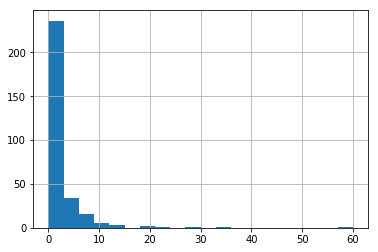

In [121]:
lead_hist = buffalo_lead['lead_ppb'].hist(bins = 20)

## Mapping

I did some basic map visualization that should be available shortly on my website (will edit with link). 
It is immediately clear how sparse and clustered the sampling is; there are large areas on the map that have not been sampled at all.

In [122]:
import folium

import branca.colormap as cm

max_lead = buffalo_lead['lead_ppb'].max()
min_lead = buffalo_lead['lead_ppb'].min()



buffalo_coord = [42.8864, -78.8784]


map_buffalo = folium.Map(location=buffalo_coord, zoom_start=12,tiles='cartodbpositron', width = 640, height=480)

for index, row in buffalo_lead.iterrows():
    shade = 'blue'
    if row['lead_ppb'] > 2.0:
        shade = 'red'
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=1, color=shade, fill_color=shade).add_to(map_buffalo)

map_buffalo.add_child(folium.LatLngPopup())

map_buffalo

## Next step: merging in housing data

The next step of the preprocessing involved getting housing data. Unlike Flint, Buffalo publishes their municipal data [on an open portal](https://data.buffalony.gov/). So it was a relatively simple task to query the [2018-2019 Assessment Roll](https://data.buffalony.gov/Government/2018-2019-Assessment-Roll/kckn-jafw) and grab the features I needed (`home age` and `property value` for each residence)

The `retrieve_assessment_data` function searches for matches to the properties based on matching street name `Prop_Num_str` and matching street number `PropStreet`. 

### joblib caching

We are using a public API provided by the City of Buffalo. Each call is relatively time consuming and repeating calls would waste time and computing resources. We elected to use joblib to cache a list of server responses on disk. The ` @memory.cache` decorator will return the cached responses if they are available on disk, so we can re-run that cell without re-running the time intensive and compute intensive task.

In [123]:
cachedir = '.'
memory = Memory(cachedir, verbose=0)

@memory.cache
def retrieve_assessment_data(df):
    responses = []
    for index, row in df.iterrows():
        r = requests.get('https://data.buffalony.gov/resource/kckn-jafw.json', {'hsenofr': row['Prop_Num_str'], 'street':row['PropStreet'].upper()})
        json_resp = r.json()
        responses.append(json_resp)
        time.sleep(0.5)
    return responses


Here we run the function we defined above, pulling the data from the server or from the cache. Once we have the list, we iterate through and access the `totalval` home value and `yrbuilt` home age data we require for our model.

In [124]:
#assessment_data = retrieve_assessment_data(buffalo_lead)
assessment_data = []

In [125]:
data = {}

for index, assessment in enumerate(assessment_data):
    try:
        data[index] = {'SEV' : assessment[0]['totalval'], 'yearBuilt' : assessment[0]['yrblt'],
                       'lat' : assessment[0]['latitude'], 'lon' : assessment[0]['longitude']}
    except:
        pass

This approach worked well enough as a "first-pass" approach, but there were a few issues with our results. Of the 300 samples in Buffalo, we've only been able to get a home value and home age for 252 of them using this primary method. And once we start looking at distances, it's clear that some of our matches were not correct (some addresses are located kilometers away from their supposed locations - I'll go into this more in depth once we have the final dataframe.)

It's clear we'll need to use a more flexible approach to find and join the appropriate addresses.

The [2018-2019 Assessment Roll](https://data.buffalony.gov/Government/2018-2019-Assessment-Roll/kckn-jafw) is available for download, and I know that the [US Census Bureau maintains an online tool](https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form) for processing addresses. It will take a bit of preprocessing and postprocessing to get this data, but it's a much more scalable solution and I hope it will ultimately get us better results! 

## Geocoding using the US Census Bureau tool

### Formatting the Lead Data

The Census Bureau tool requires a very specific input format, with house number and street name in one field, city in the next, then state, then 5-digit zip code. 

Here I put together a . I made a mistake initially, if you are, be sure to cast the `ZIP CODE (5-DIGIT)` column to string before 

In [126]:
address_segs = buffalo_lead['address'].str.split(',', expand=True)
street_city = address_segs.loc[:,0].str.split()
street_city_df = pd.DataFrame([[' '.join(val[:-1]), val[-1]] for val in street_city.tolist()])
address_seg_processed = pd.concat([street_city_df, address_segs.loc[:,1:2]], axis = 1)

In [127]:
with open('data/lead_buffalo_addresses.csv', 'w+') as f:
    address_seg_processed.to_csv(f)

Here, we have downloaded the [2018-2019 Assessment Roll](https://data.buffalony.gov/Government/2018-2019-Assessment-Roll/kckn-jafw) and open it up in a dataframe.

In [128]:
assessment_df = pd.read_csv('data/2019-2020_Assessment_Roll.csv')

C:\Users\gushi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Formatting assessment data

The Census Bureau tool requires a very specific input format, with house number and street name in one field, city in the next, then state, then 5-digit zip code. 

Here I put together a . I made a mistake initially, if you are, be sure to cast the `ZIP CODE (5-DIGIT)` column to string before 

In [129]:
assessment_df['NUMBER_STREETNAME'] = assessment_df['HOUSE NUMBER'].astype(str) + ' ' + assessment_df['STREET']
assessment_addrs = assessment_df[['NUMBER_STREETNAME', 'CITY', 'STATE', 'ZIP CODE (5-DIGIT)']]
with open('data/assessment_buffalo_addresses.csv', 'w+') as f:
    assessment_addrs.to_csv(f)

The Census Bureau tool requires input files to be below 10,000 rows. This routine splits the large csv file into smaller csv files that can be processed by the Census Bureau tool.

In [130]:
assessment_addrs.shape[0]

n = 9900
assessment_addr_blocks = [assessment_addrs[i:i + n] for i in range(0, len(assessment_addrs), n)]

for index, block in enumerate(assessment_addr_blocks):
    path = 'data/buffalo_lead_{}_preprocessed.csv'.format(index)
    with open(path, 'w+') as f:
        block.to_csv(f)

### Submitting assessment addresses and processing results

I have considered, and will look into that if I have time at the end of the project. 

Now that we have all of the, we can provide a list of them to open into a dataframe:

In [131]:
geocoded_results_list = ['data/GeocodeResults (10).csv',
'data/GeocodeResults (11).csv',
'data/GeocodeResults (12).csv',
'data/GeocodeResults (3).csv',
'data/GeocodeResults (4).csv',
'data/GeocodeResults (5).csv',
'data/GeocodeResults (6).csv',
'data/GeocodeResults (7).csv',
'data/GeocodeResults (8).csv',
'data/GeocodeResults (9).csv']

cols = ['id', 'addr', 'match', 'type', 'addr_proc', 'latlon', 'census_id', 'ind']

dfs_from_results = [pd.read_csv(f, error_bad_lines = True, names=cols) for f in geocoded_results_list]
geocoded_results_concat = pd.concat(dfs_from_results, ignore_index=True)


In [132]:
geocoded_results_concat['addr'].count()

94355

So now our objective is to get this new data joined back in with the assessment data. First we have to figure out what column we should use to join these tables:

In [133]:
geocoded_results_concat = geocoded_results_concat[pd.notnull(geocoded_results_concat['id'])]
geocoded_results_concat.id = geocoded_results_concat.id.astype(int)
geocoded_results_concat.set_index('id', inplace=True)
geocoded_results_concat.head()

,addr,match,type,addr_proc,latlon,census_id,ind
id,,,,,,,
78200,"33 MAPLERIDGE, BUFFALO, NY, 14215.0",Match,Non_Exact,"33 MAPLE RIDGE AVE, BUFFALO, NY, 14215","-78.82791,42.928722",48296633.0,R
78202,"25 SUSSEX, BUFFALO, NY, 14215.0",Match,Non_Exact,"25 SUSSEX ST, BUFFALO, NY, 14215","-78.82784,42.927242",48296640.0,R
78201,"230 THOMPSON, BUFFALO, NY, 14207.0",Match,Non_Exact,"230 THOMPSON ST, BUFFALO, NY, 14207","-78.90083,42.939716",48286667.0,L
78204,"544 FULTON, BUFFALO, NY, 14210.0",Match,Non_Exact,"544 FULTON ST, BUFFALO, NY, 14210","-78.85113,42.87043",48327609.0,L
78203,"127 GATCHELL, BUFFALO, NY, 14212.0",Match,Non_Exact,"127 GATCHELL ST, BUFFALO, NY, 14212","-78.81494,42.89977",48301353.0,R


In [134]:
assessment_df.head()

,SBL,TAX DISTRICT,PRINT KEY,FRONT,DEPTH,PROPERTY CLASS,PROPERTY CLASS DESCRIPTION,PREVIOUS PROPERTY CLASS,OWNER1,OWNER2,...,LATITUDE,LONGITUDE,LOCATION,Police Districts,Council Districts,Tracts,Tax Districts,Neighborhoods,:@computed_region_kwzn_pe6v,NUMBER_STREETNAME
0,1014500005049000,147005,101.45-5-49,36.0,190.0,210,ONE FAMILY DWELLING,210.0,LEWIS ARTHUR HENRY &,LEWIS FRANCINE,...,42.909690,-78.834188,"(42.90969023630841, -78.8341880257519)",3.0,9.0,4.0,6.0,35.0,4.0,128 URBAN
1,1233400007029000,147014,123.34-7-29,34.0,120.0,482,DOWNTOWN ROW TYPE (DETACHED),482.0,HECTOR'S HARDWARE OF,CLINTON ST INC,...,42.871551,-78.804129,"(42.87155123327281, -78.80412870868247)",4.0,2.0,21.0,12.0,34.0,17.0,1955 CLINTON
2,0904700003006000,147010,90.47-3-6,30.0,125.0,210,ONE FAMILY DWELLING,210.0,THOMAS ELLA MAE,NaN,...,42.932603,-78.821054,"(42.93260269937904, -78.82105391583222)",2.0,9.0,39.0,7.0,13.0,11.0,656 NORTHUMBERLAND
3,0787500001013000,147009,78.75-1-13,35.0,125.0,220,TWO FAMILY DWELLING,220.0,PIZZUTO JOHN & W,NaN,...,42.947110,-78.844457,"(42.947110354404096, -78.84445703567764)",5.0,7.0,37.0,2.0,25.0,18.0,246 STARIN
4,1237200001020100,147014,123.72-1-20.1,70.0,129.0,220,TWO FAMILY DWELLING,220.0,COYLE ROBERT W & W,NaN,...,42.859037,-78.818517,"(42.85903737633056, -78.8185166852207)",4.0,6.0,10.0,12.0,19.0,19.0,60 RIVERVIEW


In [135]:
assessment_data_coded = assessment_df.join(geocoded_results_concat)

In [136]:
assessment_data_coded.columns

Index(['SBL', 'TAX DISTRICT', 'PRINT KEY', 'FRONT', 'DEPTH', 'PROPERTY CLASS',
       'PROPERTY CLASS DESCRIPTION', 'PREVIOUS PROPERTY CLASS', 'OWNER1',
       'OWNER2', 'MAIL1', 'MAIL2', 'MAIL3', 'MAIL4', 'HOUSE NUMBER', 'STREET',
       'ADDRESS', 'CITY', 'STATE', 'ZIP CODE (5-DIGIT)', 'ZIP CODE (4-DIGIT)',
       'DEED BOOK', 'DEED PAGE', 'DEED DATE', 'ROLL', 'LAND VALUE',
       'TOTAL VALUE', 'SALE PRICE', 'YEAR BUILT', 'TOTAL LIVING AREA',
       'OVERALL CONDITION', 'BUILDING STYLE', 'HEAT TYPE', 'BASEMENT TYPE',
       '# OF FIREPLACES', '# OF BEDS', '# OF BATHS', 'COUNCIL DISTRICT',
       'POLICE DISTRICT', 'CENSUS TRACT', 'CENSUS BLOCK GROUP', 'CENSUS BLOCK',
       'NEIGHBORHOOD', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'Police Districts',
       'Council Districts', 'Tracts', 'Tax Districts', 'Neighborhoods ',
       ':@computed_region_kwzn_pe6v', 'NUMBER_STREETNAME', 'addr', 'match',
       'type', 'addr_proc', 'latlon', 'census_id', 'ind'],
      dtype='object')

In [137]:
#assessment_data_coded['lat'] = assessment_data_coded
lat_lon = assessment_data_coded['latlon'].str.split(',', expand=True)
lat_lon[0]
assessment_data_coded['lon'], assessment_data_coded['lat'] = lat_lon[0].astype(float), lat_lon[1].astype(float)

In [138]:
"""
TODO:
-Finish processing of the Buffalo data
    -Re-join census-processed assessment data to the original assessment data
    -Pull distances and look at those 

    -Run the buffalo lead data through the census treatment
    -Join buffalo lead data to the census - processed assessment data
    -Definitely look at distances here

"""

'\nTODO:\n-Finish processing of the Buffalo data\n    -Re-join census-processed assessment data to the original assessment data\n    -Pull distances and look at those \n\n    -Run the buffalo lead data through the census treatment\n    -Join buffalo lead data to the census - processed assessment data\n    -Definitely look at distances here\n\n'

Now we are closer, with 282 meaning we have only 18 left to go. I will do the final 18 by hand. 

Before we get to that, I would like to check that we have the correct addresses joined up by calculating the distance between the assessment data and the lead data. I'll be using the `geopy` library.

In [139]:
import geopy.distance



def grab_distances(df):
    distances = []
    for index, row in df.iterrows():
        try:
            point1 = (row['LATITUDE'], row['LONGITUDE'])
            point2 = (row['lat'], row['lon'])
            distances.append(geopy.distance.distance(point1, point2).m)
        except:
            pass
    return distances

lead_dist = grab_distances(assessment_data_coded)
len([dist for dist in lead_dist if dist > 5.0])



86325

In [140]:
len([dist for dist in lead_dist if dist > 100.0])

5085

In [141]:
#Look into the string distance as another metric 

In [142]:
with open('data/buffalo_lead_preprocessed.csv', 'w+') as f:
    buffalo_lead.to_csv(f)

In [143]:
buffalo_lead_na = buffalo_lead[buffalo_lead.isna().any(axis=1)]
buffalo_lead_na.shape

(0, 10)

In [144]:
r = requests.get('https://data.buffalony.gov/resource/kckn-jafw.json', {'latitude': row['Prop_Num_str'], 'street':row['PropStreet'].upper()})

In [163]:
cols = ['id', 'addr_orig', 'match', 'type', 'addr_proc', 'latlon', 'census_id', 'ind']
lead_bflo = pd.read_csv('data/lead_buffalo_addresses_geocode.csv', error_bad_lines = True, names=cols)
lead_bflo.dropna(inplace=True)
#lead_bflo.index = lead_bflo.index.astype(int)
lead_bflo.shape
lead_bflo.id = lead_bflo.id.astype(int)

In [160]:
lead_bflo.set_index('id', inplace=True)

In [153]:
lead_bflo.head()

,addr_orig,match,type,addr_proc,latlon,census_id,ind
id,,,,,,,
230,"348 Phyllis Avenue, Buffalo, NY, 14215",Match,Exact,"348 PHYLLIS AVE, BUFFALO, NY, 14215","-78.80058,42.935837",48297269.0,L
110,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L
111,"572 Spring Street, Buffalo, NY, 14204",Match,Exact,"572 SPRING ST, BUFFALO, NY, 14204","-78.85926,42.89286",48291221.0,L
232,"150 Ideal Street, Buffalo, NY, 14206",Match,Exact,"150 IDEAL ST, BUFFALO, NY, 14206","-78.80752,42.88855",48301532.0,L
112,"150 Ideal, Buffalo, NY, 14206",Match,Non_Exact,"150 IDEAL ST, BUFFALO, NY, 14206","-78.80752,42.88855",48301532.0,L


In [148]:
assessment_data_coded.columns

Index(['SBL', 'TAX DISTRICT', 'PRINT KEY', 'FRONT', 'DEPTH', 'PROPERTY CLASS',
       'PROPERTY CLASS DESCRIPTION', 'PREVIOUS PROPERTY CLASS', 'OWNER1',
       'OWNER2', 'MAIL1', 'MAIL2', 'MAIL3', 'MAIL4', 'HOUSE NUMBER', 'STREET',
       'ADDRESS', 'CITY', 'STATE', 'ZIP CODE (5-DIGIT)', 'ZIP CODE (4-DIGIT)',
       'DEED BOOK', 'DEED PAGE', 'DEED DATE', 'ROLL', 'LAND VALUE',
       'TOTAL VALUE', 'SALE PRICE', 'YEAR BUILT', 'TOTAL LIVING AREA',
       'OVERALL CONDITION', 'BUILDING STYLE', 'HEAT TYPE', 'BASEMENT TYPE',
       '# OF FIREPLACES', '# OF BEDS', '# OF BATHS', 'COUNCIL DISTRICT',
       'POLICE DISTRICT', 'CENSUS TRACT', 'CENSUS BLOCK GROUP', 'CENSUS BLOCK',
       'NEIGHBORHOOD', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'Police Districts',
       'Council Districts', 'Tracts', 'Tax Districts', 'Neighborhoods ',
       ':@computed_region_kwzn_pe6v', 'NUMBER_STREETNAME', 'addr', 'match',
       'type', 'addr_proc', 'latlon', 'census_id', 'ind', 'lon', 'lat'],
      dtype='object

In [167]:
lead_bflo_coded = lead_bflo.merge(assessment_data_coded, on='addr_proc', how='inner')

In [170]:
#lead_bflo_coded.dropna(inplace=True)
lead_bflo_coded.shape

(279, 69)

In [171]:
lead_bflo_coded.columns

Index(['id', 'addr_orig', 'match_x', 'type_x', 'addr_proc', 'latlon_x',
       'census_id_x', 'ind_x', 'SBL', 'TAX DISTRICT', 'PRINT KEY', 'FRONT',
       'DEPTH', 'PROPERTY CLASS', 'PROPERTY CLASS DESCRIPTION',
       'PREVIOUS PROPERTY CLASS', 'OWNER1', 'OWNER2', 'MAIL1', 'MAIL2',
       'MAIL3', 'MAIL4', 'HOUSE NUMBER', 'STREET', 'ADDRESS', 'CITY', 'STATE',
       'ZIP CODE (5-DIGIT)', 'ZIP CODE (4-DIGIT)', 'DEED BOOK', 'DEED PAGE',
       'DEED DATE', 'ROLL', 'LAND VALUE', 'TOTAL VALUE', 'SALE PRICE',
       'YEAR BUILT', 'TOTAL LIVING AREA', 'OVERALL CONDITION',
       'BUILDING STYLE', 'HEAT TYPE', 'BASEMENT TYPE', '# OF FIREPLACES',
       '# OF BEDS', '# OF BATHS', 'COUNCIL DISTRICT', 'POLICE DISTRICT',
       'CENSUS TRACT', 'CENSUS BLOCK GROUP', 'CENSUS BLOCK', 'NEIGHBORHOOD',
       'LATITUDE', 'LONGITUDE', 'LOCATION', 'Police Districts',
       'Council Districts', 'Tracts', 'Tax Districts', 'Neighborhoods ',
       ':@computed_region_kwzn_pe6v', 'NUMBER_STREETNAME', 'addr'

In [158]:
assessment_data_coded.loc[assessment_data_coded['addr_proc'].str.contains(r"348 PHYLLIS AVE, BUFFALO, NY, 14215")]

ValueError: cannot index with vector containing NA / NaN values

In [172]:
#assessment_data_coded['lat'] = assessment_data_coded
lat_lon = lead_bflo_coded['latlon_y'].str.split(',', expand=True)
lat_lon[0]
lead_bflo_coded['lon'], lead_bflo_coded['lat'] = lat_lon[0].astype(float), lat_lon[1].astype(float)

In [175]:
lead_dist = grab_distances(lead_bflo_coded)
len([dist for dist in lead_dist if dist > 100.0])

8

In [178]:
lead_bflo_coded

,id,addr_orig,match_x,type_x,addr_proc,latlon_x,census_id_x,ind_x,SBL,TAX DISTRICT,...,:@computed_region_kwzn_pe6v,NUMBER_STREETNAME,addr,match_y,type_y,latlon_y,census_id_y,ind_y,lon,lat
0,230,"348 Phyllis Avenue, Buffalo, NY, 14215",Match,Exact,"348 PHYLLIS AVE, BUFFALO, NY, 14215","-78.80058,42.935837",48297269.0,L,0904300001023000,147010,...,11.0,348 PHYLLIS,"348 PHYLLIS, BUFFALO, NY, 14215.0",Match,Non_Exact,"-78.80058,42.935837",48297269.0,L,-78.800580,42.935837
1,110,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.864670,42.865110
2,239,"14 Tenesee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.864670,42.865110
3,22,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.864670,42.865110
4,54,"14 Tennessee, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.864670,42.865110
5,167,"14 Tennesee Street, Buffalo, NY, 14204",Match,Non_Exact,"14 TENNESSEE ST, BUFFALO, NY, 14204","-78.86467,42.86511",48291757.0,L,1224700003003000,147001,...,16.0,14 TENNESSEE,"14 TENNESSEE, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.86467,42.86511",48291757.0,L,-78.864670,42.865110
6,111,"572 Spring Street, Buffalo, NY, 14204",Match,Exact,"572 SPRING ST, BUFFALO, NY, 14204","-78.85926,42.89286",48291221.0,L,1114000005005000,147003,...,16.0,572 SPRING,"572 SPRING, BUFFALO, NY, 14204.0",Match,Non_Exact,"-78.85926,42.89286",48291221.0,L,-78.859260,42.892860
7,232,"150 Ideal Street, Buffalo, NY, 14206",Match,Exact,"150 IDEAL ST, BUFFALO, NY, 14206","-78.80752,42.88855",48301532.0,L,1125000002012000,147012,...,17.0,150 IDEAL,"150 IDEAL, BUFFALO, NY, 14206.0",Match,Non_Exact,"-78.80752,42.88855",48301532.0,L,-78.807520,42.888550
8,112,"150 Ideal, Buffalo, NY, 14206",Match,Non_Exact,"150 IDEAL ST, BUFFALO, NY, 14206","-78.80752,42.88855",48301532.0,L,1125000002012000,147012,...,17.0,150 IDEAL,"150 IDEAL, BUFFALO, NY, 14206.0",Match,Non_Exact,"-78.80752,42.88855",48301532.0,L,-78.807520,42.888550
9,233,"72 Potomac Avenue, Buffalo, NY, 14213",Match,Exact,"72 POTOMAC AVE, BUFFALO, NY, 14213","-78.89655,42.92408",48288744.0,L,0887400001022000,147007,...,2.0,72 POTOMAC,"72 POTOMAC, BUFFALO, NY, 14213.0",Match,Non_Exact,"-78.89655,42.92408",48288744.0,L,-78.896550,42.924080


In [ ]:
"""
https://galaxydatatech.com/2017/12/31/fuzzy-string-matching-pandas-fuzzywuzzy/
https://github.com/seatgeek/fuzzywuzzy
https://bergvca.github.io/2017/10/14/super-fast-string-matching.html
"""